In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# !cp /content/drive/MyDrive/data_bb1_img_recognition.zip /content/

In [ ]:
# !unzip data_bb1_img_recognition.zip -d /content/dataset/

In [ ]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import ResNet101V2


In [ ]:
# load data
LOADPATH = '/content/dataset/train/'
SAVEPATH = '/content/models/'
df = pd.read_csv(LOADPATH+'labels.csv')
df_labeled = df[df["skin_tone"].notna()] # take only labeled data

# Converting labels to np array
cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]
Y = []
for i in range(3):
    lab = lbs[i].fit_transform(df_labeled[cat[i]])
    if lab.shape[1]==1:
        Y.append(np.hstack((1-lab,lab)))
    else:
        Y.append(lab)

In [ ]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
nn = df_labeled.shape[0]
all_imgs = [image.load_img(LOADPATH+df_labeled.iloc[i]['name'], target_size=(length,width)) for i in range(nn)]

print("Converting images to np array")
X = np.empty([nn, length, width, 3], dtype=float)
for i in range(nn):
    X[i,:] = image.img_to_array(all_imgs[i])
X = K.applications.resnet_v2.preprocess_input(X)


Loading images
Converting images to np array


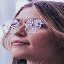

In [ ]:
all_imgs[1234] # print a test image

In [ ]:
class PredictionModel():
    def __init__(self, X, Y, idx):
        self.X = X
        self.Y = Y
        self.idx = idx
        self.trainX, self.testX = X[idx[0],:], X[idx[1],:]
        self.trainY, self.testY = [Y[i][idx[0],:] for i in range(3)], [Y[i][idx[1],:] for i in range(3)]
        self.cat = ['skin_tone','gender','age']
        self.loss = ['categorical_crossentropy' for i in range(3)]
        self.metrics = [['accuracy'] for i in range(3)]
        self.models = [None]*3

    # train a model specific for a certain class index in self.cat
    def fit(self, index, model, epochs=5, batch_size=16, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training model for "+self.cat[index])
        model.add(K.layers.Dense(self.trainY[index].shape[1], activation='softmax'))
        model.compile(loss=self.loss[index], optimizer='Adam', metrics=self.metrics[index])
        model.fit(
            self.trainX, self.trainY[index], 
            validation_data=(self.testX,self.testY[index]), 
            batch_size=batch_size, epochs=epochs, verbose=verbose
        )
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'model_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        self.models[index] = model
            
    def predict(self, newX):
        predictions = [model.predict(newX) for model in self.models]
        return predictions


In [ ]:
# function to initialize a model
def initializeModel():
    res_model = ResNet101V2(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    # # freeze all but the last layer
    for layer in res_model.layers[:376]:
      layer.trainable = False
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    return model

nntrain = int(0.7*nn)
np.random.seed(42)
indices = np.random.permutation(nn)
train_idx, test_idx = indices[:nntrain], indices[nntrain:]
mymodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])

# train model
for i in range(3):
    mymodel.fit(index=i, model=initializeModel(), epochs=25, save=True, save_location=SAVEPATH)

Training model for skin_tone
Epoch 1/25
375/375 [==============================] - 23s 38ms/step - loss: 2.5966 - accuracy: 0.1360 - val_loss: 2.1146 - val_accuracy: 0.2042
Epoch 2/25
375/375 [==============================] - 13s 36ms/step - loss: 2.2748 - accuracy: 0.1669 - val_loss: 2.0776 - val_accuracy: 0.2054
Epoch 3/25
375/375 [==============================] - 12s 31ms/step - loss: 2.1605 - accuracy: 0.1856 - val_loss: 2.0610 - val_accuracy: 0.2054
Epoch 4/25
375/375 [==============================] - 13s 36ms/step - loss: 2.1094 - accuracy: 0.1809 - val_loss: 2.0401 - val_accuracy: 0.2132
Epoch 5/25
375/375 [==============================] - 12s 31ms/step - loss: 2.0797 - accuracy: 0.1964 - val_loss: 2.0319 - val_accuracy: 0.2155
Epoch 6/25
375/375 [==============================] - 12s 31ms/step - loss: 2.0598 - accuracy: 0.2038 - val_loss: 2.0225 - val_accuracy: 0.2171
Epoch 7/25
375/375 [==============================] - 12s 31ms/step - loss: 2.0472 - accuracy: 0.2098 - val

In [ ]:
# load labels data
TESTPATH = '/content/dataset/test/'
df_test = pd.read_csv(TESTPATH+'labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet_v2.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


In [ ]:
pred = mymodel.predict(testX)
predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]
predLabels = [[lbs[i].classes_[j] for j in predY[i]] for i in range(3)]


94/94 [==============================] - 4s 25ms/step


In [ ]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[cat[i]], predLabels[i])
    acc[icat] = iacc

# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = cat[i]
    idisp = disparity_score(df_test[cat[i]], predLabels[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results


{'accuracy': {'skin_tone': 0.22666666666666666,
  'gender': 0.7383333333333333,
  'age': 0.5346666666666666},
 'disparity': {'skin_tone': 0.41467889908256883,
  'gender': 0.09195522544199186,
  'age': 0.6112695867443104}}

In [ ]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = '8-Bit Bias Bounty Baseline'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}
submission

{'submission_name': '8-Bit Bias Bounty Baseline',
 'score': 4.9193051354942385,
 'metrics': {'accuracy': {'skin_tone': 0.22666666666666666,
   'gender': 0.7383333333333333,
   'age': 0.5346666666666666},
  'disparity': {'skin_tone': 0.41467889908256883,
   'gender': 0.09195522544199186,
   'age': 0.6112695867443104}}}

In [ ]:
with open("evad_score.json", "w") as f:
    json.dump(submission, f, indent=4)